In [1]:
import numpy as np
from numpy.linalg import eig
from qiskit_algorithms.optimizers import SLSQP
from qiskit.circuit.library import TwoLocal, EfficientSU2
from qiskit.primitives import Estimator
from qiskit_algorithms import VQE
from qiskit.quantum_info import Operator
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from scipy.optimize import minimize

Based on the following Qiskit tutorial: https://learning.quantum.ibm.com/tutorial/variational-quantum-eigensolver

# Let's define the operator:

In [2]:
hamiltonian = SparsePauliOp.from_list(
    [("YZ", 0.3980), ("ZI", -0.3980), ("ZZ", -0.0113), ("XX", 0.1810)]
)

In [3]:
H = hamiltonian.to_matrix()
print(H)

[[-0.4093+0.j     0.    +0.j     0.    -0.398j  0.181 +0.j   ]
 [ 0.    +0.j    -0.3867+0.j     0.181 +0.j     0.    +0.398j]
 [ 0.    +0.398j  0.181 +0.j     0.4093+0.j     0.    +0.j   ]
 [ 0.181 +0.j     0.    -0.398j  0.    +0.j     0.3867+0.j   ]]


In [4]:
hamiltonian_operator = Operator(hamiltonian)
hamiltonian_operator.draw(output='latex')

<IPython.core.display.Latex object>

# Let's find eigenvalues using classical numpy linear algebra package:

In [5]:
e,v=eig(H)
print("Eigenvalues:", e)
print("Eigenvectors:\n", v)

Eigenvalues: [-0.70293039+6.24707871e-18j -0.45308083-7.57079461e-17j
  0.70293039-6.06797210e-18j  0.45308083+3.47628378e-17j]
Eigenvectors:
 [[ 6.49638715e-01+0.00000000e+00j -1.13885050e-18+6.65864932e-01j
   7.01111754e-18-3.30320834e-01j -1.59629506e-01-4.32331142e-17j]
 [-2.91446790e-16+6.01307531e-01j  7.03606721e-01+0.00000000e+00j
   3.27546851e-01-2.90500924e-17j -2.28717515e-17+1.89947086e-01j]
 [-3.02255009e-17-3.30320834e-01j  1.59629506e-01+8.31587415e-17j
   6.49638715e-01+0.00000000e+00j  1.18760305e-16-6.65864932e-01j]
 [-3.27546851e-01-1.37383111e-16j -1.35473761e-17+1.89947086e-01j
  -1.69472202e-17-6.01307531e-01j  7.03606721e-01+0.00000000e+00j]]


# ...or even find smallest eigenvalue with Qiskit wrapper over classical numpy eigensolver:

In [6]:
from qiskit_algorithms import NumPyMinimumEigensolver

numpy_solver = NumPyMinimumEigensolver()
result = numpy_solver.compute_minimum_eigenvalue(operator=hamiltonian)
minimal_eigenvalue = result.eigenvalue.real
print(minimal_eigenvalue)

-0.702930394459531


# Now, let's use VQE algorithm

In [7]:
ansatz = EfficientSU2(hamiltonian.num_qubits)

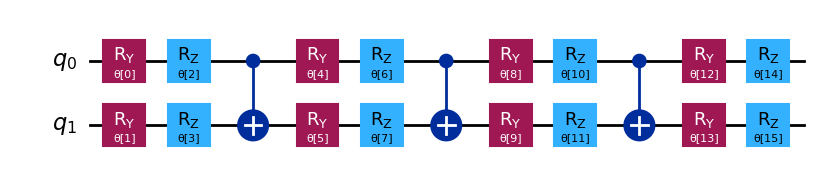

In [8]:
ansatz.decompose().draw("mpl")

In [9]:
num_params = ansatz.num_parameters
print(num_params)

16


In [10]:
print(hamiltonian.num_qubits)

2


In [11]:
def cost_func(params, ansatz, hamiltonian, estimator):
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    costs.append(energy)
    print(f"Iteration: {len(costs)+1}, cost: {energy}")

    return energy

In [12]:
costs = []

In [13]:
from qiskit_ibm_runtime.fake_provider import FakeManilaV2

fake_manila = FakeManilaV2()

In [14]:
pm = generate_preset_pass_manager(backend=fake_manila, optimization_level=1)

ansatz_isa = pm.run(ansatz)
hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

x0 = 2 * np.pi * np.random.random(num_params)
print(x0)

[3.19379151 5.05140959 1.27434452 0.95904696 1.37602971 3.27145817
 4.8226121  5.69649556 4.08005573 2.68536176 0.67155553 2.14665029
 0.74712925 4.87211545 1.42817315 0.54428764]


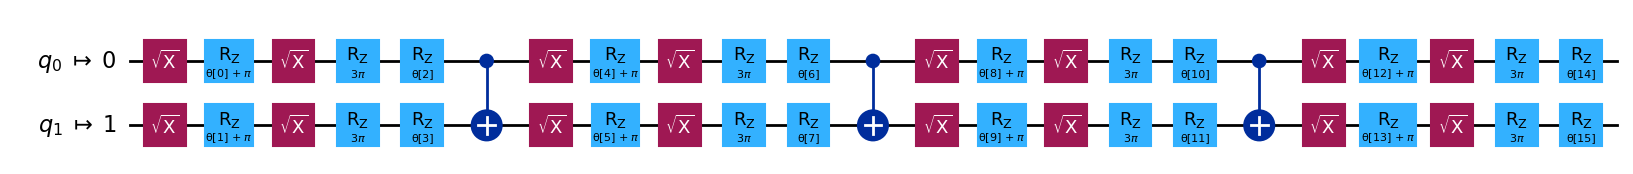

In [15]:
ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [16]:
with Session(backend=fake_manila) as session:
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 10000

    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, hamiltonian_isa, estimator),
        method="cobyla",
    )

Iteration: 2, cost: -0.14079256
Iteration: 3, cost: -0.19082302
Iteration: 4, cost: 0.016444819999999992
Iteration: 5, cost: -0.37665528000000004
Iteration: 6, cost: -0.24778900000000006
Iteration: 7, cost: -0.25843938000000005
Iteration: 8, cost: -0.08429162000000001
Iteration: 9, cost: -0.40833202
Iteration: 10, cost: -0.16886566000000003
Iteration: 11, cost: -0.35680737999999995
Iteration: 12, cost: -0.33583106
Iteration: 13, cost: -0.36236462
Iteration: 14, cost: -0.43458204000000006
Iteration: 15, cost: -0.47252700000000003
Iteration: 16, cost: -0.29501334
Iteration: 17, cost: -0.41939418
Iteration: 18, cost: -0.34355098
Iteration: 19, cost: -0.21257766000000003
Iteration: 20, cost: -0.4254976
Iteration: 21, cost: -0.24444475999999998
Iteration: 22, cost: -0.43750484000000006
Iteration: 23, cost: -0.48545366
Iteration: 24, cost: -0.44389622
Iteration: 25, cost: -0.47524940000000004
Iteration: 26, cost: -0.44446942
Iteration: 27, cost: -0.48864941999999995
Iteration: 28, cost: -0.4

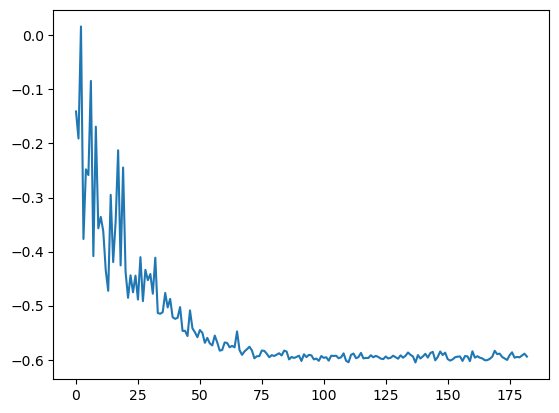

In [17]:
import matplotlib.pyplot as plt

plt.plot(costs)

# Exercise 1
Rework the above VQE example to return correct value of smallest eigenvalue (-0.59 found instead of -0.7)

In [157]:
new_ansatz = TwoLocal(num_qubits, "ry", "cz")

# Exercise 2:
Using VQE algorithm calculate ground state energy of hydrogen molecule described by the below Hamiltonian.\
Use the first ansatz we used above - not the one from Exercise 1.\
Check in the internet if the result is correct and deduce in what units it is expressed.

In [153]:
H2_op = SparsePauliOp.from_list(
    [
        ("II", -1.052373245772859),
        ("IZ", 0.39793742484318045),
        ("ZI", -0.39793742484318045),
        ("ZZ", -0.01128010425623538),
        ("XX", 0.18093119978423156),
    ]
)